In [1]:
# Train - val - test split of dataset

# Data set generation

In [2]:
#!/usr/bin/env python3
import random
seed = 10
random.seed(seed)
import copy
import numpy as np
np.random.seed(seed)

In [3]:


import sys
import time
import csv
import os
import math
from datetime import datetime
from numpy import array
from fenics import *
from reaktoro import *
from mpi4py import MPI as pyMPI





################
## PARAMETERS ##
################
# temporal
total_time = 40000                  # final time
num_steps = 105                     # number of time steps
dt = 200                            # time step size
t = 0                               # initial time
# chemical
temperature = 60.0                  # the temperature (in units of degC)
pressure = 100                      # the pressure (in units of bar)
# transport
transported_species = ['Cl-', 'Ca++', 'Mg++'] # reduced list of transported species
influx_mgclcl = 1                    # influx concentration (mol/m3)
# spatial
porosity = 0.32                      # porosity
a = 0.0                             #1D line [a,b]. Given the number of cells (nx) i
b = 0.5

geo_ml_path = '/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml'

nx = 1000
# +- % that will be used to create extra data
log_level = int(2)
set_log_level(30)
##############
## REAKTORO ##
##############
# Construct the chemical system with its phases and species
editor = ChemicalEditor()
editor.addAqueousPhase("H2O(l) H+ OH- Ca++ Cl- HCO3- Mg++")
editor.addMineralPhase('Quartz') # SiO2
editor.addMineralPhase('Calcite') # CaCO3
editor.addMineralPhase('Dolomite') # CaCO3
system = ChemicalSystem(editor)
# chemical state for initial condition 
problem_ic = EquilibriumProblem(system)
problem_ic.setTemperature(temperature, 'celsius')
problem_ic.setPressure(pressure, 'bar')
problem_ic.add('H2O', 1.0, 'kg')
problem_ic.add('CaCO3', 10, 'mol')
problem_ic.add('SiO2', 10, 'mol')
state_ic = equilibrate(problem_ic)
# chemical state for boundary condition
problem_bc = EquilibriumProblem(system)
problem_bc.setTemperature(temperature, 'celsius')
problem_bc.setPressure(pressure, 'bar')
problem_bc.add('H2O', 1.0, 'kg')
problem_bc.add('MgCl2', influx_mgclcl, 'mol')
state_bc = equilibrate(problem_bc)
# volume scaling
state_ic.scalePhaseVolume('Aqueous', porosity, 'dm3') # corresponds to the initial porosity of 10%.
state_ic.scalePhaseVolume('Quartz', (1-porosity-0.017-0.001), 'dm3')
state_ic.scalePhaseVolume('Calcite', 0.018, 'dm3')
state_bc.scalePhaseVolume('Dolomite', 0.00, 'dm3')
state_bc.scalePhaseVolume('Aqueous', porosity, 'dm3') # corresponds to the initial porosity of 10%.
state_bc.scalePhaseVolume('Quartz', (1-porosity-0.001-0.001), 'dm3')
state_bc.scalePhaseVolume('Calcite', 0.002, 'dm3')
state_bc.scalePhaseVolume('Dolomite', 0.00, 'dm3')
# list of chemical states
field = []
for i in range(0, nx):
    state_ic = equilibrate(problem_ic)
    # Step 9: Scale the volumes of the phases in the initial condition
    state_ic.scalePhaseVolume('Aqueous', porosity, 'dm3') # corresponds to the initial porosity of 10%.
    state_ic.scalePhaseVolume('Quartz', (1-porosity-0.017-0.001), 'dm3')
    state_ic.scalePhaseVolume('Calcite', 0.018, 'dm3')
    state_ic.scalePhaseVolume('Dolomite', 0.000, 'dm3')
    field.append(state_ic)


state_dummy = equilibrate(problem_ic)
state_dummy.scalePhaseVolume('Aqueous', porosity, 'dm3') # corresponds to the initial porosity of 10%.
state_dummy.scalePhaseVolume('Quartz', (1-porosity-0.017-0.001), 'dm3')
state_dummy.scalePhaseVolume('Calcite', 0.018, 'dm3')
state_dummy.scalePhaseVolume('Dolomite', 0.000, 'dm3')

############
## FENICS ##
############
comm = MPI.comm_world
rank = comm.Get_rank()  # no AttributeError
mesh = IntervalMesh(comm, nx, a,b)
V = FunctionSpace(mesh, 'CG', 1)

entries_data = 0
# boundary conditions
def boundary_L(x, on_boundary):
    tol = 1E-10
    return on_boundary and near(x[0], 0.0, tol)

def boundary_R(x, on_boundary):
    tol = 1E-10
    return on_boundary and near(x[0], 0.5, tol)

bcl_list = []
bcr_list = []
print("Transported species:", transported_species)
for index_species, i in enumerate(transported_species):
    bcl_list.append(DirichletBC(V, Constant(state_bc.speciesAmount(i)/porosity), boundary_L))
    bcr_list.append(DirichletBC(V, Constant(state_ic.speciesAmount(i)/porosity), boundary_R))


# Define initial value
u_0_list = [Expression(str(state_ic.speciesAmount(i)), element=V.ufl_element()) for i in transported_species]
u_n_list = [interpolate(i, V) for i in u_0_list]

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("0.0", element=V.ufl_element())
g = Expression("0.0", element=V.ufl_element())

D0 = Constant(9.375e-5 * 0.0067)
adv_v = Constant(9.375e-5)
De = Constant(D0 * porosity)
a_list = []
L_list = []
u_list = []

W= VectorFunctionSpace(mesh, 'CG',1)
advector = Function(W)

advec = Vector(MPI.comm_world,nx+1)
advec = advec+1
advector.vector().set_local(advec)


for index, i in enumerate(transported_species):
    u_0 = u_n_list[index]
    F = dot(u,v)*dx + dt*adv_v*dot(advector,grad(u))*v*dx + dt*De*dot(grad(u), grad(v))*dx - (u_0)*v*dx
    a, L = lhs(F), rhs(F)
    a_list.append(a)
    L_list.append(L)
    u_ref = Function(V)
    u_ref.rename(i,'species_conc')
    u_list.append(u_ref)


# Time-stepping
u = Function(V)
t = 0
iteration = 0

# OUTPUT 
date_time = datetime.now().strftime("%m_%d_%Y_%H%M%S")
output_file = 'output'
path_output_csv = geo_ml_path+'/training_data/data/'+output_file+'_'+date_time +'.csv'
csvFile_output= open(path_output_csv, 'w')
# csv writer library
writer_csv_output = csv.writer(csvFile_output)

csv_headers_output = ['iteration','node', 'x', 'C' ,'Ca','Cl','H','O', 'Mg']#,'Ca(CO3)@', 'Ca(HCO3)+','Ca+2','CaOH+','Mg(CO3)@','Mg(HCO3)+','Mg+2','MgOH+','CO2@','CO3-2','HCO3-','CH4@','ClO4-','Cl-','H2@','O2@','OH-','H+','H2O@','Cal','Dis-Dol','Sn']
# transported species
for i in transported_species:
    csv_headers_output.append(i)
# calcite
csv_headers_output.append('Calcite')
csv_headers_output.append('Dolomite')
# writes the header into the file
writer_csv_output.writerow(csv_headers_output)
elements_output_index = [0,1,2,3,4,5] # Si and Z are out

print("Input neural network header: ", csv_headers_output[3:9])
print("Output neural network header: ", csv_headers_output[9:])



# print("Data generator log level:", log_level)

def data_generator(state_new_deep, entries_data, log_level):
    if 100-log_level < 0:
        raise SystemExit("Please, use a proper log level (smaller than 100).")
    for i in range(100-log_level, 100+log_level):
        original = state.speciesAmounts()
        state_new_deep.setSpeciesAmounts(state.speciesAmounts()*i/100)
        equilibrate(state_new_deep)
        # write it out
        new_row = []
        new_row.append(str(-1))
        new_row.append(str(-1))
        new_row.append(str(-1))
        # OUTPUT 
        for element_index, element_amount in enumerate(state_new_deep.elementAmounts()):
            if element_index in elements_output_index:
                new_row.append(element_amount)
        # Gets the transported species composition
        for index_species, species_name in enumerate(transported_species):
            new_row.append(state_new_deep.speciesAmount(species_name))
        # calcite
        new_row.append(state_new_deep.speciesAmount("Calcite"))
        new_row.append(state_new_deep.speciesAmount("Dolomite"))
        entries_data += 1
        writer_csv_output.writerow(new_row)
    


while t <= total_time: 
    print("TIME:", t , "(", t/total_time, ")")
    
    # Update current time
    t += dt
    iteration += 1
    calcite_buffer = [state_bc.speciesAmount("Calcite")]
    dolomite_buffer = [state_bc.speciesAmount("Dolomite")]

    # Compute solution from transport
    for index, i in enumerate(transported_species):
        u = Function(V)
        solve(a_list[index] == L_list[index], u, bcs=[bcl_list[index],bcr_list[index]])
        # Save to file and plot solution
        u_list[index].assign(u)
        # plot(u_list[index])
        # Update previous solution
        u_n_list[index].assign(u_list[index])

    # # TRANSPORT -> CHEMICAL
    solution_buffer = []
    for index_species, species_name in enumerate(transported_species):
        solution_buffer.append(u_n_list[index_species].vector()[:])
    # equilibrate for each node
    for state_index, state in enumerate(field):
        for index_species, (species_name, species_buffer) in enumerate(zip(transported_species, solution_buffer)):
            if species_buffer[state_index] * porosity > 0.0:
                state.setSpeciesAmount(species_name, species_buffer[state_index] * porosity)
                state_dummy.setSpeciesAmount(species_name, species_buffer[state_index] * porosity)
        equilibrate(state)
        data_generator(state_dummy, entries_data, log_level)
        calcite_buffer.append(state.speciesAmount("Calcite"))
        dolomite_buffer.append(state.speciesAmount("Dolomite"))
        # defines the new values in the buffer
        for index, i in enumerate(transported_species):
            solution_buffer[index][state_index] = state.speciesAmount(i) / porosity
            
    # moves the results back to the transport 
    for index_species, (species_name, u_0) in enumerate(zip(transported_species, u_n_list)):
        u_0.vector()[:] = copy.deepcopy(solution_buffer[index_species])

    # OUTPUT
    for state_index, state in enumerate(field):
        new_row = []
        new_row.append(str(iteration))
        new_row.append(str(state_index))
        new_row.append(str(round(state_index * b/nx, 3)))
        # OUTPUT 
        for element_index, element_amount in enumerate(state.elementAmounts()):
            if element_index in elements_output_index:
                new_row.append(element_amount)
        # Gets the transported species composition
        for index_species, species_name in enumerate(transported_species):
            new_row.append(state.speciesAmount(species_name))
        # calcite
        new_row.append(calcite_buffer[state_index])
        new_row.append(dolomite_buffer[state_index])
        entries_data += 1
        writer_csv_output.writerow(new_row)
csvFile_output.close()
print('\n')
print("Output file: ", path_output_csv, '( ', round(os.path.getsize(path_output_csv)/(1024*1024), 2), 'MB )')
print('\n')
print("Data generator successfully finished.")

Transported species: ['Cl-', 'Ca++', 'Mg++']
Input neural network header:  ['C', 'Ca', 'Cl', 'H', 'O', 'Mg']
Output neural network header:  ['Cl-', 'Ca++', 'Mg++', 'Calcite', 'Dolomite']
TIME: 0 ( 0.0 )
TIME: 200 ( 0.005 )
TIME: 400 ( 0.01 )
TIME: 600 ( 0.015 )
TIME: 800 ( 0.02 )
TIME: 1000 ( 0.025 )
TIME: 1200 ( 0.03 )
TIME: 1400 ( 0.035 )
TIME: 1600 ( 0.04 )
TIME: 1800 ( 0.045 )
TIME: 2000 ( 0.05 )
TIME: 2200 ( 0.055 )
TIME: 2400 ( 0.06 )
TIME: 2600 ( 0.065 )
TIME: 2800 ( 0.07 )
TIME: 3000 ( 0.075 )
TIME: 3200 ( 0.08 )
TIME: 3400 ( 0.085 )
TIME: 3600 ( 0.09 )
TIME: 3800 ( 0.095 )
TIME: 4000 ( 0.1 )
TIME: 4200 ( 0.105 )
TIME: 4400 ( 0.11 )
TIME: 4600 ( 0.115 )
TIME: 4800 ( 0.12 )
TIME: 5000 ( 0.125 )
TIME: 5200 ( 0.13 )
TIME: 5400 ( 0.135 )
TIME: 5600 ( 0.14 )
TIME: 5800 ( 0.145 )
TIME: 6000 ( 0.15 )
TIME: 6200 ( 0.155 )
TIME: 6400 ( 0.16 )
TIME: 6600 ( 0.165 )
TIME: 6800 ( 0.17 )
TIME: 7000 ( 0.175 )
TIME: 7200 ( 0.18 )
TIME: 7400 ( 0.185 )
TIME: 7600 ( 0.19 )
TIME: 7800 ( 0.195 )
TI

In [4]:
path_output_csv

'/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml/training_data/data/output_06_20_2023_083746.csv'

# NN TRAINING

In [5]:
# Use scikit-learn to grid search the batch size and epochs
import numpy as np
np.random.seed(seed)

import pandas as pd
import tensorflow as tf



from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import json
import glob
import matplotlib.pylab as plt
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import sys
import csv
import os
from tabulate import tabulate
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

tf.random.set_seed(seed)

In [6]:


#input_data = '/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml/training_data/data/output_083113.csv'
input_data = path_output_csv
home_geo_ml = '/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml'


nIC=6
nDC=5
names = ['C','Ca','Cl','H','O','Mg', 'Cl-', 'Ca++', 'Mg++', 'Calcite', 'Dolomite']

df = pd.read_csv(input_data, names=names, skiprows=1)



X = df.iloc[:, :nIC]
Y = df.iloc[:, nIC:]

Xtrainval, Xtest, ytrainval, ytest = train_test_split(X, Y, test_size=0.1, random_state=123)
Xtrain,Xval,ytrain,yval = train_test_split(Xtrainval,ytrainval,test_size = 0.1, random_state = 123)



In [7]:

# training default parameters
def train_model(date_time,n_epoch=500, batch_size=32,activation='relu', optimizer='Adam',initializer='uniform',
               verbose=0, layers=3, neurons=7,suffix_output=''):

    # configuration parameters -> 1 = on(saving, plotting), 0 = off(not plotting, not saving)
    plot=1
    history_save=1
    # 1 uses early stopping, 0 doesnt use
    callback=1
    es = EarlyStopping(monitor='val_loss', mode='auto', min_delta=0.000001, verbose=1, patience=50)


    print("List of arguments:", str(sys.argv))
    nIC=6
    nDC=5
    names = ['C','Ca','Cl','H','O','Mg', 'Cl-', 'Ca++', 'Mg++', 'Calcite', 'Dolomite']

    # define the keras model
    def create_model_default():
        model = Sequential()
        model.add(tf.keras.Input(shape=(6,)))
        for i in range(0,layers):
            model.add(Dense(neurons, activation=activation, kernel_initializer=initializer))
        model.add(Dense(5, activation='linear', name="speciation_output",kernel_initializer=initializer))
        model.compile(loss='mse',
                    optimizer=optimizer, 
                    metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()]) 
        return model

    # fit the keras model on the dataset
    model = create_model_default()

    callback_list = []    
#     if callback == 1:
#         callback_list.append(es)

    history = model.fit(Xtrain, ytrain, epochs=n_epoch, batch_size=batch_size, validation_data=(Xval, yval), verbose=verbose, callbacks=callback_list)
    # evaluate the keras model
    results_to_print = model.evaluate(Xtrain, ytrain)


    def plot_metrics(metric_name, title, loc_place):
#         plot_path = '/home/leonardo/software/training_plot/geo_ml/training_data/plots/'
        plot_path = home_geo_ml+'/training_data/plots/'
        plt.figure()
        plt.title(title)
        line_1, = plt.plot(history.history[metric_name], color='blue', label=metric_name)
        line_2, = plt.plot(history.history['val_' + metric_name], color='red', label='val_' + metric_name)
        plt.xlabel('epoch')
        plt.grid(True)
        plt.ylabel(metric_name)
        plt.legend([line_1, line_2], ['nn_'+metric_name, 'val_'+metric_name],fontsize=10, loc=loc_place+' right')   
    #     plt.show()
        plt.savefig(plot_path+title+'_'+date_time+'.png')
        plt.close()

#    date_time = datetime.now().strftime("%m_%d_%Y_%H%M%S")
    
    # Plot RMSE
    if plot == 1:
        plot_metrics(metric_name='accuracy', title='Accuracy', loc_place='lower')
        plot_metrics(metric_name='loss', title='Loss', loc_place='upper')
        plot_metrics(metric_name='root_mean_squared_error', title='RMSE', loc_place='upper')


    save_path = home_geo_ml+'/training_data/models/model_'+date_time+'.h5'
    model.save(save_path)

    names = ['model file', 'Loss', 'Accuracy', 'RMSE']

    loss_output = [results_to_print[0]]
    accuracy_output = [results_to_print[1]]
    rmse_output = [results_to_print[2]]


    print('\n')
    print("Output plots available in : "+home_geo_ml+"/training_data/plots/")
    print('\n')

    model_output = [save_path.split('/')[-1]]
    print('\n\n\n')
    table = zip(model_output, loss_output, accuracy_output, rmse_output)
    print(tabulate(table, headers=names, floatfmt=".10f"))
    print('\n')
    print(model.summary())






    predictions = model.predict(Xval)
    def plot_diff(y_true, y_pred, title=''):
        plot_path = home_geo_ml+'/training_data/plots/'
        plt.figure()
        plt.scatter(y_true, y_pred)
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.axis('equal')
        plt.axis('square')
        plt.xlim(plt.xlim())
        plt.grid(True)
        plt.ylim(plt.ylim())
        plt.plot([-100, 100], [-100, 100])
    #     plt.show()
        plt.savefig(plot_path+'evaluation_'+date_time+'.png')
        plt.close()

    if plot == 1:
        plot_diff(yval, predictions, title="Testing reloaded model") 

    if history_save != 0:
        save_path_history_pred = home_geo_ml+'/training_data/prediction/model_'+date_time+'_'+suffix_output+'.csv'
        csv_headers_output = ['pred_Cl-','pred_Ca++','pred_Mg++','pred_Calcite','pred_Dolomite', 'val_Cl-','val_Ca++','val_Mg++','val_Calcite','val_Dolomite']
        csvFile_output= open(save_path_history_pred, 'w')
        writer_csv_output = csv.writer(csvFile_output)
        writer_csv_output.writerow(csv_headers_output)
        for index, row in enumerate(yval.itertuples()):
            new_row = []
            for i in predictions[index]:
                new_row.append(i)          
            new_row.append(row._1)  
            new_row.append(row._2)  
            new_row.append(row._3)  
            new_row.append(row.Calcite) 
            new_row.append(row.Dolomite) 
            writer_csv_output.writerow(new_row)
        csvFile_output.close()


    if history_save != 0:
        # Save it under the form of a json file
        save_path_history = home_geo_ml+'/training_data/history/model_'+date_time+'.csv'
        pd.DataFrame.from_dict(history.history).to_csv(save_path_history,index=False)

    return model, history
        

In [8]:
n_epoch_list = [100]
history_list =[]
date_time = datetime.now().strftime("%m_%d_%Y_%H%M%S")
for n_epoch in n_epoch_list:
    model, history = train_model(date_time,n_epoch=n_epoch,suffix_output='epoch_'+str(n_epoch), verbose=1)
    history_list.append(history.history)

List of arguments: ['/mnt/disk1/anaconda3/envs/fenicsproject/lib/python3.7/site-packages/ipykernel_launcher.py', '-f', '/afs/psi.ch/user/b/boiger_r/.local/share/jupyter/runtime/kernel-ee8f2e20-95a0-4ede-a600-9f5408a1966e.json']
Epoch 1/100


2023-06-20 08:40:26.738737: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 08:40:26.877998: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-20 08:40:26.890044: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


25440/25440 [==============================] - 13s 516us/step - loss: 0.0035 - accuracy: 0.9786 - root_mean_squared_error: 0.0514 - val_loss: 2.2387e-05 - val_accuracy: 0.9983 - val_root_mean_squared_error: 0.0047
Epoch 2/100
25440/25440 [==============================] - 13s 528us/step - loss: 2.3327e-05 - accuracy: 0.9985 - root_mean_squared_error: 0.0048 - val_loss: 1.9818e-05 - val_accuracy: 0.9985 - val_root_mean_squared_error: 0.0045
Epoch 3/100
25440/25440 [==============================] - 13s 499us/step - loss: 2.1928e-05 - accuracy: 0.9985 - root_mean_squared_error: 0.0047 - val_loss: 2.0519e-05 - val_accuracy: 0.9979 - val_root_mean_squared_error: 0.0045
Epoch 4/100
25440/25440 [==============================] - 13s 511us/step - loss: 2.1045e-05 - accuracy: 0.9985 - root_mean_squared_error: 0.0046 - val_loss: 2.2400e-05 - val_accuracy: 0.9984 - val_root_mean_squared_error: 0.0047
Epoch 5/100
25440/25440 [==============================] - 14s 540us/step - loss: 1.9733e-05 - a

25440/25440 [==============================] - 13s 530us/step - loss: 1.7011e-05 - accuracy: 0.9990 - root_mean_squared_error: 0.0041 - val_loss: 1.9525e-05 - val_accuracy: 0.9987 - val_root_mean_squared_error: 0.0044
Epoch 37/100
25440/25440 [==============================] - 13s 509us/step - loss: 1.8730e-05 - accuracy: 0.9989 - root_mean_squared_error: 0.0043 - val_loss: 1.6725e-05 - val_accuracy: 0.9996 - val_root_mean_squared_error: 0.0041
Epoch 38/100
25440/25440 [==============================] - 14s 533us/step - loss: 1.8135e-05 - accuracy: 0.9989 - root_mean_squared_error: 0.0043 - val_loss: 1.5764e-05 - val_accuracy: 0.9992 - val_root_mean_squared_error: 0.0040
Epoch 39/100
25440/25440 [==============================] - 14s 568us/step - loss: 1.7864e-05 - accuracy: 0.9990 - root_mean_squared_error: 0.0042 - val_loss: 1.6065e-05 - val_accuracy: 0.9988 - val_root_mean_squared_error: 0.0040
Epoch 40/100
25440/25440 [==============================] - 13s 522us/step - loss: 1.7815

25440/25440 [==============================] - 12s 455us/step - loss: 1.7713e-05 - accuracy: 0.9990 - root_mean_squared_error: 0.0042 - val_loss: 1.6043e-05 - val_accuracy: 0.9992 - val_root_mean_squared_error: 0.0040
Epoch 72/100
25440/25440 [==============================] - 12s 462us/step - loss: 1.7777e-05 - accuracy: 0.9991 - root_mean_squared_error: 0.0042 - val_loss: 1.6068e-05 - val_accuracy: 0.9990 - val_root_mean_squared_error: 0.0040
Epoch 73/100
25440/25440 [==============================] - 12s 459us/step - loss: 1.8176e-05 - accuracy: 0.9992 - root_mean_squared_error: 0.0043 - val_loss: 1.5770e-05 - val_accuracy: 0.9987 - val_root_mean_squared_error: 0.0040
Epoch 74/100
25440/25440 [==============================] - 12s 479us/step - loss: 1.6751e-05 - accuracy: 0.9992 - root_mean_squared_error: 0.0041 - val_loss: 1.6376e-05 - val_accuracy: 0.9985 - val_root_mean_squared_error: 0.0040
Epoch 75/100
25440/25440 [==============================] - 12s 483us/step - loss: 1.8513

In [9]:
from datetime import datetime
#ate_time = datetime.now().strftime("%H%M%S")
save_path = home_geo_ml+'/training_data/models/model_'+date_time+'.h5'
model.save(save_path)
print(save_path)

/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml/training_data/models/model_06_20_2023_084026.h5


# NN performance

Text(0, 0.5, 'loss')

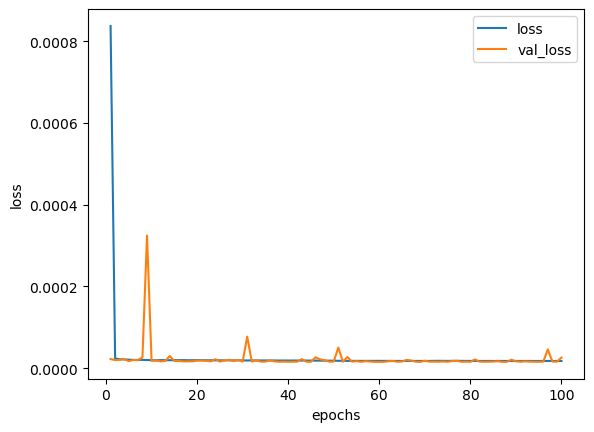

In [11]:
# plot of model history
plt.plot(np.arange(n_epoch)+1,history_list[0]['loss'],label = 'loss')
plt.plot(np.arange(n_epoch)+1,history_list[0]['val_loss'],label = 'val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')


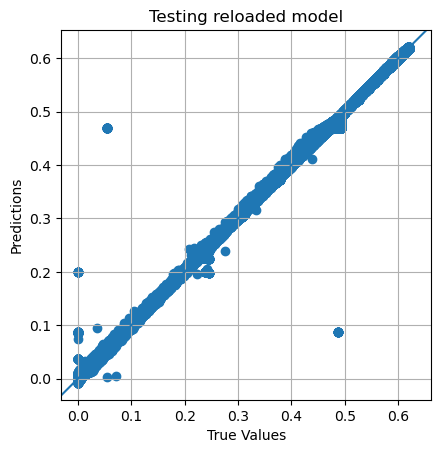

In [12]:
predictions = model.predict(Xtest)
def plot_diff(y_true, y_pred, title=''):
    plot_path = '/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml/training_data/plots'

    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.grid(True)
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
#     plt.show()
    plt.savefig(plot_path+'evaluation_'+date_time+'.png')
    #plt.close()
plot_diff(ytest, predictions, title="Testing reloaded model") 

In [13]:
# Performance of NN

In [14]:
predictions = pd.DataFrame(predictions, columns = ytest.columns)

In [15]:
ytest = ytest.reset_index(drop=True)
ytest

Cl-          Ca++      Mg++       Calcite  Dolomite
0       0.614909  6.667679e-07  0.307455  1.226550e-21  0.243691
1       0.614909  4.103501e-07  0.307455  1.191256e-21  0.243690
2       0.614909  1.167242e-07  0.307455  1.108477e-21  0.243686
3       0.621058  3.553423e-07  0.310529  1.180191e-21  0.246127
4       0.621058  1.314229e-07  0.310529  1.114761e-21  0.246124
...          ...           ...       ...           ...       ...
100495  0.614909  1.015507e-06  0.307456  1.258939e-21  0.243692
100496  0.614909  1.675631e-07  0.307455  1.130698e-21  0.243688
100497  0.614909  2.473627e-07  0.307455  1.156157e-21  0.243689
100498  0.602611  4.677687e-06  0.301309  1.394818e-21  0.238821
100499  0.608760  1.832982e-07  0.304380  1.137115e-21  0.241251

[100500 rows x 5 columns]

In [16]:
predictions

Cl-      Ca++      Mg++   Calcite  Dolomite
0       0.613806 -0.003103  0.311377  0.002626  0.244453
1       0.613806 -0.003103  0.311377  0.002626  0.244453
2       0.613803 -0.003104  0.311376  0.002626  0.244453
3       0.619756 -0.003348  0.314632  0.002499  0.245806
4       0.619754 -0.003349  0.314631  0.002500  0.245806
...          ...       ...       ...       ...       ...
100495  0.613807 -0.003103  0.311377  0.002626  0.244453
100496  0.613804 -0.003103  0.311376  0.002626  0.244453
100497  0.613804 -0.003103  0.311376  0.002626  0.244453
100498  0.603531  0.000358  0.302785  0.002713  0.244384
100499  0.608664 -0.001373  0.307079  0.002670  0.244418

[100500 rows x 5 columns]

In [17]:
# # absolute error:
error = np.abs(predictions - ytest)
abs_error_table = np.round(error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',0.75: '75%',0.9: '90%',0.95: '95%',0.99: '99%',}), decimals=5)
abs_error_table

Cl-     Ca++     Mg++  Calcite  Dolomite
50%  0.00110  0.00310  0.00392  0.00263   0.00077
75%  0.00130  0.00335  0.00392  0.00271   0.00557
90%  0.00188  0.00337  0.00410  0.00357   0.00576
95%  0.00268  0.00461  0.00410  0.01155   0.00798
99%  0.00371  0.00512  0.00418  0.02226   0.00832

In [18]:
# relative error:
rel_error = error/np.abs(ytest) *100
rel_error = pd.DataFrame(rel_error, columns=ytest.columns).abs()
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',0.75: '75%',0.9: '90%',0.95: '95%',0.99: '99%',}), decimals=5)
rel_error_table

Cl-          Ca++          Mg++       Calcite      Dolomite
50%      0.17944  3.689084e+05       1.27546  2.189206e+20  3.158900e-01
75%      0.20958  9.121449e+05       1.32099  2.287757e+20  2.330800e+00
90%      0.45790  1.887089e+06       9.17072  2.384367e+20  1.462008e+01
95%      2.18052  3.003702e+06     140.39882  2.450323e+20  4.862813e+04
99%  40677.43007  6.570029e+06  917534.26070  2.593241e+20  8.316547e+19

In [19]:
def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE


In [20]:
# wmape
wMAPE_ytest = wmape(ytest, predictions)
wMAPE_ytest = pd.DataFrame(wMAPE_ytest).T
wMAPE_ytest

Cl-       Ca++      Mg++  Calcite  Dolomite
0  0.19406  14.494143  1.165611  7.11053  1.278556

In [21]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2
    

In [22]:
#R2 value
metric = RSquaredSeparated()
r2_adj = metric.call(ytest.values, predictions).numpy()
r2_adj = pd.Series(data=r2_adj, index=ytest.columns)
r2_adj = pd.DataFrame(r2_adj).T
r2_adj

Cl-      Ca++      Mg++   Calcite  Dolomite
0  0.999912  0.997794  0.998873  0.995411  0.996471

In [30]:
# MSE
MSE_list = []
import sklearn
for col in ytest.columns:
    MSE = sklearn.metrics.mean_squared_error(ytest[col], predictions[col])
    MSE_list.append(MSE)
    print(col,': MSE: ',MSE)
MSE_list = np.array(MSE_list)
print('MSE :',MSE_list.mean())

Cl- : MSE:  1.7593254009706566e-06
Ca++ : MSE:  7.849817895942478e-06
Mg++ : MSE:  1.0946997104934184e-05
Calcite : MSE:  0.00010028564773466763
Dolomite : MSE:  1.9340615755552325e-05
MSE : 2.8036480778413453e-05


In [31]:
# RMSE
RMSE_list = []
import sklearn
for col in ytest.columns:
    RMSE = sklearn.metrics.mean_squared_error(ytest[col], predictions[col],squared=False)
    RMSE_list.append(RMSE)
    print(col,': RMSE: ',RMSE)
RMSE_list = np.array(RMSE_list)
print('RMSE :',RMSE_list.mean())



Cl- : RMSE:  0.0013263956426989108
Ca++ : RMSE:  0.002801752647173279
Mg++ : RMSE:  0.0033086246545859783
Calcite : RMSE:  0.010014272201945963
Dolomite : RMSE:  0.004397796693294533
RMSE : 0.004369768367939732


In [32]:
r2_adj.loc[1] = MSE_list
r2_adj.loc[2] = RMSE_list
r2_adj = r2_adj.rename(index = {0:'r2',1:'MSE',2:'RMSE'})
r2_adj['mean'] = r2_adj.mean(axis = 1)
r2_adj

Cl-      Ca++      Mg++   Calcite  Dolomite      mean
r2    0.999912  0.997794  0.998873  0.995411  0.996471  0.997692
MSE   0.000002  0.000008  0.000011  0.000100  0.000019  0.000028
RMSE  0.001326  0.002802  0.003309  0.010014  0.004398  0.004370

In [33]:
#use_ann = False
import sys
import os
import copy
import numpy as np
import time
import csv
np.random.seed(seed)
import time as tm
from datetime import datetime

use_ann = True
for use_ann  in [True,False]:
    print(use_ann)
    nn_model = save_path#'/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml/training_data/models/model_121737.h5'
    home_geo_ml='/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml'
    ### !/usr/bin/env python3


    if use_ann:
        import tensorflow as tf
        from tensorflow.keras.models import Model
        from tensorflow.keras.layers import Dense, Input
        # VERBOSE
        tf.random.set_seed(seed)
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # or any {DEBUG, INFO, WARN, ERROR, FATAL}


        
        

    #use_ann = False
    from tabulate import tabulate
    from fenics import *
    from reaktoro import *
    from mpi4py import MPI as pyMPI

    from react_transport.logging_custom import Logging, Bcolors

    set_log_level(30)

    # Defines initial simulation time
    cpu_time_start = tm.perf_counter()
    start_simulation_time = str(datetime.now())

    # chemical
    temperature = 60.0                  # the temperature (in units of degC)
    pressure = 100                      # the pressure (in units of bar)
    total_time = 40000            # final time
    num_steps = 105     # number of time steps
    dt = 200 # time step size
    t = 0
    # Create mesh and define function space
    porosity = 0.32
    nx = 50
    comm = MPI.comm_world
    b = 0.5
    a = 0.0
    mesh = IntervalMesh(comm, nx, a, b)
    V = FunctionSpace(mesh, 'CG', 1)



    transported_species = ['Cl-', 'Ca++', 'Mg++'] # reduced list of transported species
    influx_mgclcl = 1.0   





    model = tf.keras.models.load_model(nn_model,compile=False)


    ##############
    ## REAKTORO ##
    ##############

    # Construct the chemical system with its phases and species
    editor = ChemicalEditor()
    editor.addAqueousPhase("H2O(l) H+ OH- Ca++ Cl- HCO3- Mg++")
    editor.addMineralPhase('Quartz') # SiO2
    editor.addMineralPhase('Calcite') # CaCO3
    editor.addMineralPhase('Dolomite') # CaMg(CO3)2
    system = ChemicalSystem(editor)
    # matrix to reconstruct bulk ic
    matrix = system.formulaMatrix()
    # chemical state for initial condition 
    problem_ic = EquilibriumProblem(system)
    problem_ic.setTemperature(temperature, 'celsius')
    problem_ic.setPressure(pressure, 'bar')
    problem_ic.add('H2O', 1.0, 'kg')
    problem_ic.add('CaCO3', 10, 'mol')
    problem_ic.add('SiO2', 10, 'mol')
    state_ic = equilibrate(problem_ic)
    # chemical state for boundary condition
    problem_bc = EquilibriumProblem(system)
    problem_bc.setTemperature(temperature, 'celsius')
    problem_bc.setPressure(pressure, 'bar')
    problem_bc.add('H2O', 1.0, 'kg')
    problem_bc.add('MgCl2', influx_mgclcl, 'mol')

    state_bc = equilibrate(problem_bc)
    # volume scaling
    state_ic.scalePhaseVolume('Aqueous', porosity, 'dm3')
    state_ic.scalePhaseVolume('Quartz', (1-porosity-0.017-0.001), 'dm3')
    state_ic.scalePhaseVolume('Calcite', 0.018, 'dm3')
    state_ic.scalePhaseVolume('Dolomite', 0.000, 'dm3')
    state_bc.scalePhaseVolume('Aqueous', porosity, 'dm3')
    state_bc.scalePhaseVolume('Quartz', (1-porosity-0.000-0.001), 'dm3')
    state_bc.scalePhaseVolume('Calcite', 0.002, 'dm3')
    state_bc.scalePhaseVolume('Dolomite', 0.000, 'dm3')
    field = []
    calcite_buffer = [state_bc.speciesAmount("Calcite")]
    dolomite_buffer = [state_bc.speciesAmount("Dolomite")]
    for i in range(0, nx):
        state_ic = equilibrate(problem_ic)
        # Step 9: Scale the volumes of the phases in the initial condition
        state_ic.scalePhaseVolume('Aqueous', porosity, 'dm3')
        state_ic.scalePhaseVolume('Quartz', (1-porosity-0.017-0.001), 'dm3')
        state_ic.scalePhaseVolume('Calcite', 0.018, 'dm3')
        state_ic.scalePhaseVolume('Dolomite', 0.000, 'dm3')
        calcite_buffer.append(state_ic.speciesAmount("Calcite"))
        dolomite_buffer.append(state_ic.speciesAmount("Dolomite"))
        field.append(state_ic)

    state_bulk_ic = equilibrate(problem_ic)
    state_bulk_ic.scalePhaseVolume('Aqueous', porosity, 'dm3')
    state_bulk_ic.scalePhaseVolume('Quartz', (1-porosity-0.017-0.001), 'dm3')
    state_bulk_ic.scalePhaseVolume('Calcite', 0.018, 'dm3')
    state_bulk_ic.scalePhaseVolume('Dolomite', 0.000, 'dm3')

    state_bulk_bc = equilibrate(problem_bc)
    state_bulk_bc.scalePhaseVolume('Aqueous', porosity, 'dm3')
    state_bulk_bc.scalePhaseVolume('Quartz', (1-porosity-0.001-0.00), 'dm3')
    state_bulk_bc.scalePhaseVolume('Calcite', 0.001, 'dm3')
    state_bulk_bc.scalePhaseVolume('Dolomite', 0.00, 'dm3')


    # Set up to define highest and lowest value for each DC
    highest_Values = [ [-1.0 for node in range(0,nx)] for i in enumerate(transported_species)]
    lowest_Values = [[100000.0 for node in range(0,nx)] for i in enumerate(transported_species)]

    def boundary_L(x, on_boundary):
        tol = 1E-10
        return on_boundary and near(x[0], 0.0, tol)

    def boundary_R(x, on_boundary):
        tol = 1E-10
        return on_boundary and near(x[0], 0.5, tol)

    # bcs in in concentration mol/m3
    bcl_list = []
    bcr_list = []
    values_bcs_amount = []
    for index_species, i in enumerate(transported_species):
        # print(i, state_bc.speciesAmount(i), state_ic.speciesAmount(i))
        values_bcs_amount.append(state_bc.speciesAmount(i) if state_bc.speciesAmount(i) > 1.0e-15 else 1.0e-15)
        bcl_list.append(DirichletBC(V, Constant(state_bc.speciesAmount(i)/porosity), boundary_L))
        bcr_list.append(DirichletBC(V, Constant(state_ic.speciesAmount(i)/porosity), boundary_R))

    values_bcs_amount.append(state_bc.speciesAmount('Calcite'))
    values_bcs_amount.append(state_bc.speciesAmount('Dolomite'))



    # Define initial value in concentration mol/m3
    u_0_list = [Expression(str(state_ic.speciesAmount(i)/porosity), element=V.ufl_element()) for i in transported_species]
    u_n_list = [interpolate(i, V) for i in u_0_list]

    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    f = Expression("0.0", element=V.ufl_element())
    g = Expression("0.0", element=V.ufl_element())

    D0 = Constant(9.375e-5 * 0.0067)
    adv_v = Constant(9.375e-5)

    De = Constant(D0 * porosity)
    a_list = []
    L_list = []
    vtk_list= []
    u_list = []
    
    W= VectorFunctionSpace(mesh, 'CG',1)
    advector = Function(W)

    advec = Vector(MPI.comm_world,51)
    advec = advec+1
    advector.vector().set_local(advec)

    for index, i in enumerate(transported_species):
        u_0 = u_n_list[index]
        F = dot(u,v)*dx + dt*adv_v*dot(advector,grad(u))*v*dx + dt*De*dot(grad(u), grad(v))*dx - (u_0)*v*dx
        a, L = lhs(F), rhs(F)
        a_list.append(a)
        L_list.append(L)
        u_ref = Function(V)
        u_list.append(u_ref)

    # Time-stepping
    u = Function(V)
    t = 0
    iteration = 0

    # OUTPUT
    output_filename = home_geo_ml+'/react_transport/output/output-reaktoro.csv'
    if use_ann:	
        output_filename = home_geo_ml+'/react_transport/output/output-nn.csv'

    csvFile_output= open(output_filename, 'w') 

    # csv writer library
    writer_csv_output = csv.writer(csvFile_output)
    csv_headers_output = ['iteration','node', 'x', 'C' ,'Ca','Cl','H','Mg', 'O']

    # transported species
    for i in transported_species:
        csv_headers_output.append(i)
    # calcite
    csv_headers_output.append('Calcite')
    csv_headers_output.append('Dolomite')
    # writes the header into the file
    writer_csv_output.writerow(csv_headers_output)

    # reconstruct aux
    n_input = 6
    # transported_species = ['H+', 'Cl-', 'Ca++', 'Mg++'] # reduced list of transported species
    input_names = ['C','Ca','Cl','H', 'Mg', 'O']
    input_indices = [0, 1, 2, 3, 4, 5]

    transport_species_element_indices = [2, 1, 4]
    n_output = 6

    nIC = len(state_ic.elementAmounts())
    speciation_default_ic = state_ic.speciesAmounts()
    speciation_default_bc = state_bc.speciesAmounts()
    bulk_default_ic = state_ic.elementAmounts()
    bulk_default_bc = state_bc.elementAmounts()
    nDC = len(state_ic.speciesAmounts())

    tbulk_amounts_0= []
    fbulk_amounts_0 = []

    for state_index in range(0,nx):
        state_organize = state_bulk_ic
        if state_index == 0:
            state_organize = state_bulk_bc
        bulk_transport = np.zeros(n_input)
        bulk_fix = np.zeros(n_input)
        # C -> NOTHING IS TRANSPORTED
        bulk_fix[0] = state_organize.elementAmounts()[0]
        bulk_transport[0] = 0.0
        # Ca -> Ca++ is transported (Calcite and Dolomite amounts belong to fix)
        # bulk_fix = calcite + dolomite
        bulk_fix[1] = state_organize.elementAmounts()[1] - state_organize.speciesAmount('Ca++')
        bulk_transport[1] = state_organize.speciesAmount('Ca++')
        # Cl -> all of Cl- is transported
        bulk_fix[2] = 0.0
        bulk_transport[2] = state_organize.speciesAmount('Cl-')
        # H -> H+ is transported
        bulk_fix[3] = state_organize.elementAmounts()[3]
        # bulk_fix[3] = state_organize.elementAmounts()[3] - state_organize.speciesAmount('H+')
        # bulk_transport[3] = state_organize.speciesAmount('H+')
        # Mg -> Mg++ is transported
        bulk_fix[4] = state_organize.elementAmounts()[4] - state_organize.speciesAmount('Mg++')
        bulk_transport[4] = state_organize.speciesAmount('Mg++')
        # O -> NOTHING IS TRANSPORTED
        bulk_fix[5] = state_organize.elementAmounts()[5]
        bulk_transport[5] = 0.0

        fbulk_amounts_0.append(bulk_fix)
        tbulk_amounts_0.append(bulk_transport)


    # CHECK IF SYSTEM IS WELL FORMED 
    # bulk check: bulk_fix + bulk_transport == state.elementAmounts()
    for state_index in range(0,nx):
        # ic state
        state_organize = state_bulk_ic
        if state_index == 0:
            # bc state == 0
            state_organize = state_bulk_bc
        # transported species
        f_m_bulks = fbulk_amounts_0[state_index] + tbulk_amounts_0[state_index]
        state_bulk = state_organize.elementAmounts()[:6] 
        for i,z in zip(f_m_bulks, state_bulk):
            if i != z:
                raise SystemExit("ERROR: problem with the initial fix & transport bulks.")

    min_species_indices = [8,9]
    min_phase_indices = [2,3]

    # validate initial vector for transported species Cl-
    def test_transport_variable_debug(name, limit_node):
        for index, transp_name in enumerate(transported_species):
            if name == transp_name:
                transport_index = index
                element_index = transport_species_element_indices[index]
                element_name = input_names[element_index]
                break
        array_vector_conc = u_n_list[transport_index].vector().get_local()[:limit_node]
        aux_dict = {}
        aux_dict["name"] = name
        aux_dict["transport_index"] = transport_index
        aux_dict["u_transport_vector_concentration"]= array_vector_conc
        aux_dict["u_transport_vector_amount"] = array_vector_conc* porosity
        aux_dict["element_name"] =  element_name
        aux_dict["bulk_element_index"] =  element_index
        aux_dict["fbulk_amounts_0"] = [ i[element_index] for i in fbulk_amounts_0[:limit_node]]
        # aux_dict["fbulk_amounts"] = [ i[element_index] for i in fbulk_amounts[:nx]]
        aux_dict["tbulk_amounts_0"] = [ i[element_index] for i in tbulk_amounts_0[:limit_node]]
        # aux_dict["tbulk_amounts"] = [ i[element_index] for i in tbulk_amounts_0[:nx]]
        # calcite
        aux_dict['element_amount_in_calcite'] = [ calcite_value * matrix[element_index][8] for calcite_value in  calcite_buffer[:limit_node]] 
        # dolomite
        aux_dict['element_amount_in_dolomite'] = [ dolomite_value * matrix[element_index][9] for dolomite_value in  dolomite_buffer[:limit_node]]
        return aux_dict

    # creates the log class and 
    log = Logging(os.path.basename('teste'))
    log.status_print("\r " + Bcolors.OKBLUE + " FEniCS-XGEMS Reactive " +
                            "Transport Solver" + Bcolors.ENDC,True)
    ###########################
    # REACTIVE TRANSPORT LOOP #
    ###########################
    progress = Progress('Time-stepping')
    log.status_print(Bcolors.ERASE_LINE + Bcolors.OKBLUE + "\nFEniCS-NN" +
                            Bcolors.ENDC + " initializing reactive transport simulation...\r\n", True)

    t0 = time.time()

    time_in_transport = 0.0
    time_in_chemical = 0.0


    # time stepping routine
    while t < total_time: 
        # print("TIME:", t , "(", t/total_time, ")")
        ################
        # TIME ADVANCE #
        ################ 
        # Update current time
        t += dt
        # Update iteration number
        iteration += 1 
        # adds the BCs value for calcite and dolomite buffers
        calcite_buffer = [state_bc.speciesAmount("Calcite")]
        dolomite_buffer = [state_bc.speciesAmount("Dolomite")]

        diff_fbulk_ca = []
        diff_fbulk_mg = []
        # solution buffers
        solution_buffer = []
        # solves the transport step for each transported species

        for index_transport, i in enumerate(transported_species):

            u = Function(V)
            t_init_transport = time.time()
            solve(a_list[index_transport] == L_list[index_transport], u, bcs=[bcl_list[index_transport],bcr_list[index_transport]])
            time_in_transport += time.time() - t_init_transport
            # Save to file and plot solution
            u_list[index_transport].assign(u)


            # assigns the new solution to the transport and to the buffer
            u_n_list[index_transport].assign(u_list[index_transport])
            solution_buffer.append(np.clip(u_n_list[index_transport].vector().get_local(), 1.0e-15, None))
            # Inverse the array for proper boundary conditions
            solution_buffer[-1] = solution_buffer[-1][::-1]
            # update the tbulk vec
            index_bulk = transport_species_element_indices[index_transport]
            tbulk_amounts_0[:][index_bulk] = copy.deepcopy(solution_buffer[index_transport] * porosity)

            # min and max values
            maxValue = np.max(solution_buffer[-1])
            minValue = np.min(solution_buffer[-1])
            if maxValue > np.max(highest_Values[index_transport]):
                highest_Values[index_transport]=maxValue*porosity
            if minValue < np.max(lowest_Values[index_transport]):
                lowest_Values[index_transport]=minValue*porosity


        # RECONSTRUCT BULK TO GET PREDICTIONS
        current_bulks = []
        for state_index in range(0,nx):
            if state_index == 0:
                bulk_state = copy.deepcopy(fbulk_amounts_0[state_index] + tbulk_amounts_0[state_index])
            else:
                # fixed bulk amount from state_index
                # bulk_state = copy.deepcopy(fbulk_amounts_0[state_index][:] + tbulk_amounts_0[state_index][:])
                bulk_state = copy.deepcopy(fbulk_amounts_0[state_index][:])
                # removes the previous transport amount and sets the new one
                # C -> Nothing is transported
                # Ca -> transport index 2 bulk index 1
                bulk_state[1] += solution_buffer[1][state_index] * porosity + tbulk_amounts_0[state_index][1]
                # Cl -> transport index 1 bulkd index 2
                bulk_state[2] += solution_buffer[0][state_index] * porosity + tbulk_amounts_0[state_index][2]
                # H -> Nothing is transported
                # Mg -> transport index 3 bulk index 4
                bulk_state[4] += solution_buffer[2][state_index] * porosity + tbulk_amounts_0[state_index][4]
                # O -> Nothing is transported
                # REAKTORO : the chemical equilibrium for each node
                if not use_ann: 
                    # field[state_index].setSpeciesAmount('Ca++',solution_buffer[2][state_index] * porosity)
                    field[state_index].setSpeciesAmount('Ca++',solution_buffer[1][state_index] * porosity)
                    field[state_index].setSpeciesAmount('Cl-', solution_buffer[0][state_index] * porosity)
                    field[state_index].setSpeciesAmount('Mg++', solution_buffer[2][state_index] * porosity)
                    t_init_chem = time.time()
                    equilibrate(field[state_index])
                    time_in_chemical += time.time() - t_init_chem

                    # updates tbulk_amounts_0 and fbulk_amounts
                    calcite_buffer.append(field[state_index].speciesAmount("Calcite"))
                    dolomite_buffer.append(field[state_index].speciesAmount("Dolomite"))
                    # defines the new values in the buffer
                    for index_transport, species_name in enumerate(transported_species):
                        output_conc.append(solution_buffer[index_transport])

                    u_n_list[0].vector().get_local()[:] = copy.deepcopy(solution_buffer[0][::-1])
                    u_n_list[1].vector().get_local()[:] = copy.deepcopy(solution_buffer[1][::-1])
                    u_n_list[2].vector().get_local()[:] = copy.deepcopy(solution_buffer[2][::-1])

            # appends the state's bulk value
            current_bulks.append(bulk_state.tolist())


        # ANN : all nodes at once
        if use_ann:
    #         prediction = model.predict([current_bulks]).tolist()[0]
            ic_entries = tf.convert_to_tensor(current_bulks, dtype=tf.float32)
            prediction = model(ic_entries, training=False)

            calcite_buffer = []
            dolomite_buffer = []
            output_conc = []
            # for each node predicted passes the transport and mineral phases back
            for state_index, pred_values in enumerate(prediction):
                limit = 1.0e-15
                if state_index == 0:
                    solution_buffer[0][state_index] = values_bcs_amount[0] / porosity if values_bcs_amount[0] > limit else limit
                    solution_buffer[1][state_index] = values_bcs_amount[1] / porosity if values_bcs_amount[1] > limit else limit
                    solution_buffer[2][state_index] = values_bcs_amount[2] / porosity if values_bcs_amount[2] > limit else limit
                    calcite_buffer.append(values_bcs_amount[3])
                    dolomite_buffer.append(values_bcs_amount[4])
                else:
                    bulk_current = current_bulks[state_index]
                    # Cl-
                    old_cl_t_amount = solution_buffer[0][state_index] * porosity 
                    solution_buffer[0][state_index] += (pred_values[0].numpy() - bulk_current[2]) / porosity
                    tbulk_amounts_0[state_index][2] += solution_buffer[0][state_index] * porosity - old_cl_t_amount

                    # Ca++
                    old_ca_t_amount = solution_buffer[1][state_index] * porosity
                    solution_buffer[1][state_index] = pred_values[1].numpy() / porosity 
    #                 new_ca_t = tbulk_amounts_0[state_index][1]
                    diff_ca = old_ca_t_amount - solution_buffer[1][state_index] *porosity
                    # Mg++
                    old_mg_t_amount = solution_buffer[2][state_index] * porosity
                    solution_buffer[2][state_index] = pred_values[2].numpy() / porosity 
    #                 new_mg_t = tbulk_amounts_0[state_index][4]
                    diff_mg = old_mg_t_amount - solution_buffer[2][state_index] * porosity

                    # Calcite 
                    calcite_buffer.append(pred_values[3].numpy())
                    # Dolomite
                    dolomite_buffer.append(pred_values[4].numpy())
                    # Ca from minerals
                    fbulk_amounts_0[state_index][1] = calcite_buffer[state_index] + dolomite_buffer[state_index]

                    # Mg from minerals
                    fbulk_amounts_0[state_index][4] = dolomite_buffer[state_index] 

                    # update solution after adjusting minerals

                    solution_buffer[1][state_index] += diff_ca / porosity
                    solution_buffer[2][state_index] += diff_mg / porosity


        for state_index, state in enumerate(field):
            new_row = []
            new_row.append(str(iteration))
            new_row.append(str(state_index))
            new_row.append(str(round(state_index * b/nx, 3)))
            # OUTPUT 
            for index_ic, element_amounts in enumerate(current_bulks[state_index]):
                new_row.append(element_amounts)

            new_row.append(solution_buffer[0][state_index]*porosity)
            new_row.append(solution_buffer[1][state_index]*porosity)
            new_row.append(solution_buffer[2][state_index]*porosity)
            # calcite
            new_row.append(calcite_buffer[state_index])
            # dolomite
            new_row.append(dolomite_buffer[state_index])

            writer_csv_output.writerow(new_row)

        ###########################
        # updates the progress bar
        ###########################
        log.update_progress(float(t) / float(total_time), 0, iteration)
        # if iteration == 2:
        #     break

    csvFile_output.close()
    t1 = time.time()

    total_rttime = t1-t0
    print("TOTAL TIME FOR THE RT LOOP: ", total_rttime)


    if not use_ann:
        print("TOTAL TIME TRANSPORT: ", time_in_transport, '( ', time_in_transport/(time_in_transport+time_in_chemical), '%)')
        print("TOTAL TIME CHEMICAL: ", time_in_chemical, '( ', time_in_chemical/(time_in_transport+time_in_chemical), '%)')

    # print('ca', diff_fbulk_ca)
    # print('mg', diff_fbulk_mg)

    # print([sum(x) for x in zip(diff_fbulk_ca, diff_fbulk_mg)])


    

True
teste
  FEniCS-XGEMS Reactive Transport Solver
FEniCS-NN initializing reactive transport simulation...
  FEniCS-NN : [##################################################] 100% 
TOTAL TIME FOR THE RT LOOP:  4.518928289413452
False
teste
  FEniCS-XGEMS Reactive Transport Solver
FEniCS-NN initializing reactive transport simulation...
  FEniCS-NN : [##################################################] 100% 
TOTAL TIME FOR THE RT LOOP:  3.8582160472869873
TOTAL TIME TRANSPORT:  0.8251070976257324 (  0.2615460399628292 %)
TOTAL TIME CHEMICAL:  2.329622745513916 (  0.7384539600371708 %)


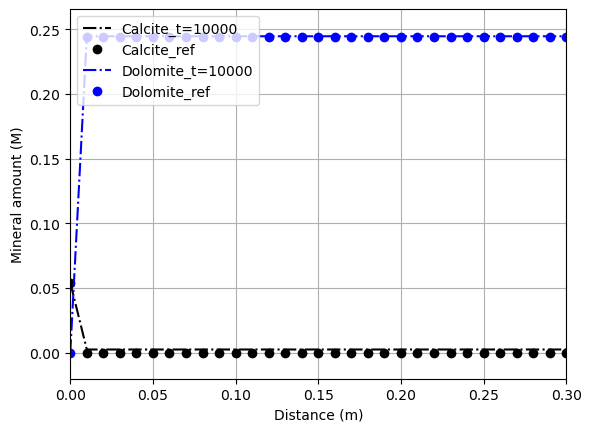

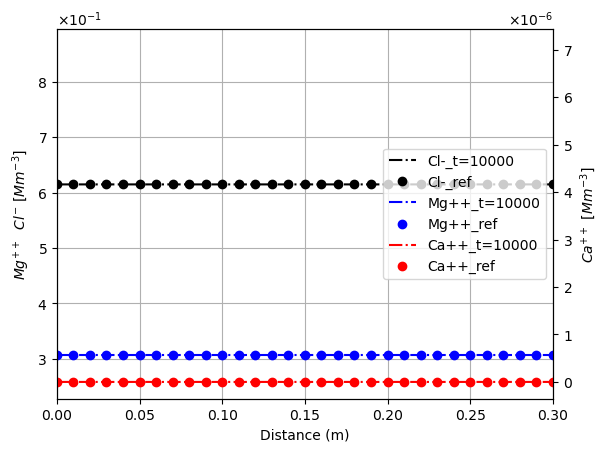

In [36]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pylab as plt
import math
import os
import sys
from datetime import datetime



outptu_file_ref = home_geo_ml+'/react_transport/output/output-reaktoro.csv'
output_file_nn = home_geo_ml+'/react_transport/output/output-nn.csv'
#date_time = datetime.now().strftime("%H%M%S")
try:
    if os.path.isfile(outptu_file_ref) and os.path.isfile(output_file_nn):
        fenics_reaktoro_df_ref = pd.read_csv(outptu_file_ref)
        fenics_reaktoro_df = pd.read_csv(output_file_nn)
except IOError:
    raise SystemExit("Output files are not accessible/nonexistant.")


# #   post processing of results
fig,ax1= plt.subplots()

iteration_list = [50]
outlist = []
outlist.append('Calcite')
outlist.append('Dolomite')

lineformat = ['-.k','ok','-.b','ob','-.r', 'or']
i=0

for name in outlist:
    for n_iteration in iteration_list:
        # NN
        current_results = fenics_reaktoro_df.loc[fenics_reaktoro_df['iteration'] == n_iteration]
        ax1.plot(current_results['x'],current_results[name],lineformat[i],label = name+"_t="+str(n_iteration*200))
        i+=1 
        # REAKTORO
        current_results_ref = fenics_reaktoro_df_ref.loc[fenics_reaktoro_df_ref['iteration'] == n_iteration]
        ax1.plot(current_results_ref['x'],current_results_ref[name],lineformat[i],label = name+"_ref")
        i+=1 
        
ax1.set_ylabel('Mineral amount (M)')
ax1.set_xlabel('Distance (m)')

plot_path = home_geo_ml+'/react_transport/output/'

h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1,fontsize=10, loc='upper left')   
# ax1.ticklabel_format(style='sci',axis='y',scilimits=(0,0),useMathText=True)
plt.xlim(0.0,0.3)
plt.grid(True)
# plt.show()
plt.savefig(plot_path+'min_forpaper'+date_time+'.png')
#plt.close()

del fig
del ax1


fenics_reaktoro_df_ref = pd.read_csv(home_geo_ml+'/react_transport/output/output-reaktoro.csv')
fenics_reaktoro_df = pd.read_csv(home_geo_ml+'/react_transport/output/output-nn.csv')

# #   post processing of results
fig,ax1= plt.subplots()
ax2 = ax1.twinx()

outlist = []
outlist2 = []

outlist.append('Cl-')
outlist2.append('Ca++')
outlist.append('Mg++')
lineformat = ['-.k','ok','-.b','ob','-.r', 'or', 'm','-k','+-b','-r','+-g','-.c', 'y', 'm', '-r','+-g','-.c', 'y', 'm','-k','+-b','-r','+-g','-.c', 'y', 'm', '-k','+-b','-r','+-g','-.c', 'y', 'm','-k','+-b','-r','+-g','-.c', 'y', 'm', '-r','+-g','-.c', 'y', 'm','-k','+-b','-r','+-g','-.c', 'y', 'm']
i=0

for name in outlist:
    for n_iteration in iteration_list:
        # NN
        current_results = fenics_reaktoro_df.loc[fenics_reaktoro_df['iteration'] == n_iteration]
        ax1.plot(current_results['x'],current_results[name],lineformat[i],label = name+"_t="+str(n_iteration*200))
        i+=1
        
        # REAKTORO
        current_results_ref = fenics_reaktoro_df_ref.loc[fenics_reaktoro_df_ref['iteration'] == n_iteration]
        ax1.plot(current_results_ref['x'],current_results_ref[name],lineformat[i],label = name+"_ref")
        i+=1

for name in outlist2:
    for n_iteration in iteration_list:
        # NN
        current_results = fenics_reaktoro_df.loc[fenics_reaktoro_df['iteration'] == n_iteration]
        ax2.plot(current_results['x'],current_results[name],lineformat[i],label = name+"_t="+str(n_iteration*200))
        i+=1
        
        # REAKTORO
        current_results_ref = fenics_reaktoro_df_ref.loc[fenics_reaktoro_df_ref['iteration'] == n_iteration]
        ax2.plot(current_results_ref['x'],current_results_ref[name],lineformat[i],label = name+"_ref")
        i+=1

ax1.set_ylabel('$Mg^{++}$  $Cl^{-}$ [$M m^{-3}$]')
ax2.set_ylabel('$Ca^{++}$ [$M m^{-3}$]')
ax1.set_xlabel('Distance (m)')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.grid(True)
# ax1.legend(h1, l1,fontsize=10, loc='upper left')   
ax1.legend(h1+h2, l1+l2, loc='right')   
ax1.ticklabel_format(style='sci',axis='y',scilimits=(0,0),useMathText=True)
ax2.ticklabel_format(style='sci',axis='y',scilimits=(0,0),useMathText=True)

plt.xlim(0.0,0.3)

# plt.show()
# 
plt.savefig(plot_path+'aqueous_forpaper'+date_time+'.png')
#plt.close()







In [37]:
nn_model

'/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml/training_data/models/model_06_20_2023_084026.h5'

In [39]:
path_output_csv

'/mnt/disk1/projects/geoml_leonardo/02-Software_and_Models/SourceCode/geoml_wp/Geoml/training_data/data/output_06_20_2023_083746.csv'